# Style transfer using CNN

This is the PyTorch implementation of an algorithm defined in these two papers: [\[1\]](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) (this present section) and [\[2\]](https://arxiv.org/pdf/1611.07865.pdf) (next section).

## Google Colab configuration cells

In [0]:
# Install the correct version of PyTorch
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [2]:
# Install some tools needed to fuse mount a google drive and retrieve images
!apt-get install -y -qq software-properties-common module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} # You may need to allow the application to access you Google account

(Reading database ... 110850 files and directories currently installed.)
Preparing to unpack .../software-properties-common_0.96.24.32.7_all.deb ...
Unpacking software-properties-common (0.96.24.32.7) over (0.96.24.32.6) ...
Preparing to unpack .../python3-software-properties_0.96.24.32.7_all.deb ...
Unpacking python3-software-properties (0.96.24.32.7) over (0.96.24.32.6) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Setting up python3-software-properties (0.96.24.32.7) ...
Processing triggers for dbus (1.12.2-1ubuntu1) ...
Setting up software-properties-common (0.96.24.32.7) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/

In [0]:
# Mount the Google Drive
!mkdir -p colabData
!google-drive-ocamlfuse colabData

## Python imports

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.models as models

from PIL import Image, ImageStat
from matplotlib.pyplot import imshow, show

import os, sys

if not torch.cuda.is_available():
    print("Can't use CUDA: computations on CPU may take a long time.")

## Parameters

In [0]:
## Algorithm parameters ##

# Layers for representing our content and style: we should pick ReLu layers 
content_layers = [22] # Layers for content representation
style_layers = [1, 6, 11, 20, 29] # Layers for style representation

# Weights for each layer loss
content_weights = [1e0] # Weights for content layers
style_weights = [1e3/n**2 for n in [64,128,256,512,512]] # Weights for style layers (these weights were found in another implementation and work great)

# We normalize our weights
content_weights = [w/sum(content_weights) for w in content_weights]
style_weights = [w/sum(style_weights) for w in style_weights]

trade_off = 3 # alpha/beta ratio: higher value means more faithful to content, while lower value means more faithful to style ; 3 is a value that will yield nice results

image_width = 512 # Resize width (will match the smaller edge of images to this value) 500 to 1000 is a sweet spot for VGG19 (convolution kernels are able to capture coarse-scale as well as fine-scale details with this size)

init_from_content = True # True if it should init optimization with the content image instead of white noise

epochs = 500 # Maximum number of iterations
show_every = 20 # Display informations and save the epoch image every show_every steps

## Code parameters (not linked to the style transfer algorithm itself) ##

images_prefix = "colabData/style-transfer/images/" # Common prefix for input images
content_path = images_prefix + "demonstration.jpg" # Content image
style_path = images_prefix + "gerard.jpg" # Style image
output_pattern = "outputs/out_{}.png" # Path pattern of output images

# Imagenet mean and std
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# Transformations to preprocess and postprocess our images
input_transforms = transforms.Compose([
    transforms.Resize(image_width), # Resize the image
    transforms.ToTensor(), # Convert to PyTorch tensor
    #transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), # Pytorch models except BGR instead of RGB ? TODO
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std), # Normalize values according to imagenet means and standard deviations
    transforms.Lambda(lambda x: x.mul_(255)), # Remap [0,1] values into [0,255] values
])

output_transforms = transforms.Compose([
    transforms.Lambda(lambda x: x.mul_(1./255)), # Remap [0,255] values into [0,1] values
    transforms.Normalize(mean=[0]*3, std=[1./std for std in imagenet_std]),
    transforms.Normalize(mean=[-mean for mean in imagenet_mean], std=[1]*3), # Denormalize
    #transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), # Pytorch models except BGR instead of RGB ? TODO
    transforms.Lambda(lambda x: x.clamp(0, 1)), # Clamp values from 0 to 1
    transforms.ToPILImage(),
])

## Model

In [0]:
class StyleTransfer(nn.Module):
    """
        Wrapper class for our style transfer using a pretrained VGG19 model
    """
    def __init__(self, content_layers=[22], style_layers=[1, 6, 11, 20, 29]):
        """
            Class constructor
            
            :param content_layers: list of layer indexes in self._model to pick for content representation
            :type content_layers: list
            :param style_layers: list of layer indexes in self._model to pick for style representation
            :type style_layers: list
        """
        super(StyleTransfer, self).__init__()
        self.style_layers = style_layers
        self.content_layers = content_layers
        self._model = models.vgg19(pretrained=True).features.eval()
        
    def forward(self, input):
        """
            Propagate an input through the layers of the model, and returns the style and content features
            
            :param input: Target content image
            :type input: torch.Tensor
        """
        out_style = []
        out_content = []
        handles = []
        for layer_index in self.style_layers:
            def hook(module, input, output):
                out_style.append(output)
            handle = self._model[layer_index].register_forward_hook(hook)
            handles.append(handle)
        
        for layer_index in self.content_layers:
            def hook(module, input, output):
                out_content.append(output)
            handle = self._model[layer_index].register_forward_hook(hook)
            handles.append(handle)
            
        self._model(input)
        
        [handle.remove() for handle in handles]
        
        return out_content, out_style

In [0]:
def gram_matrix(input):
    """
        Compute the Gram matrix of a given input
        
        :param input: input batch
        :type input: torch.Tensor
        :return: Gram matrix for the input
        :rtype: torch.Tensor
    """
    batchsize, n_filters, height, width = input.size()
    
    input_reshaped = input.view(batchsize, n_filters, -1)
    G = torch.bmm(input_reshaped, input_reshaped.transpose(1,2))
    
    return G.div(height*width)

In [0]:
def generate(model, optimizer, epochs, show_every, output, output_transforms, content_weights, style_weights, trade_off, content_targets, style_targets):
    weights = [trade_off, 1]
    alpha, beta = [w/sum(weights) for w in weights]
        
    try:
        for epoch in range(epochs+1):
            content_output, style_output = model(output)

            if torch.cuda.is_available():
                content_loss = [content_weights[i]*nn.MSELoss().cuda()(F, content_targets[i]) for i,F in enumerate(content_output)]
                style_loss = [style_weights[i]*nn.MSELoss().cuda()(gram_matrix(F), style_targets[i]) for i,F in enumerate(style_output)]
            else:
                content_loss = [content_weights[i]*nn.MSELoss()(F, content_targets[i]) for i,F in enumerate(content_output)]
                style_loss = [style_weights[i]*nn.MSELoss()(gram_matrix(F), style_targets[i]) for i,F in enumerate(style_output)]

            loss = alpha*sum(content_loss)+beta*sum(style_loss)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step(lambda: loss)

            if epoch % show_every == 0:
                print("#{}: Content loss = {}, Style loss = {}, Overall = {}".format(epoch, sum(content_loss).item(), sum(style_loss).item(), loss.item()))
                img = output_transforms(output.clone().data[0].cpu().squeeze())
                img.save(output_pattern.format(epoch))
                #imshow(img)
                #show()
            else:
                print("#{}".format(epoch))
    except KeyboardInterrupt:
        print("Manual interruption")

## Initialization

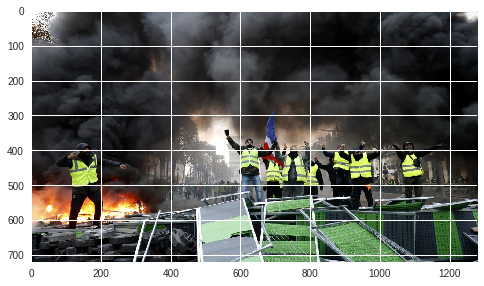

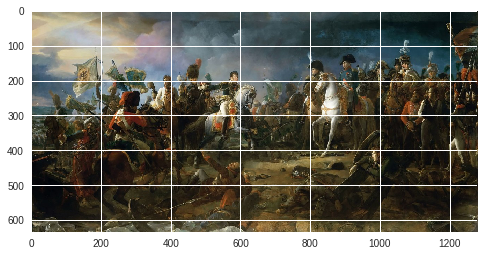

In [38]:
# Load and preprocess images
images = (Image.open(content_path), Image.open(style_path))
transformed_images = [input_transforms(i) for i in images]
if torch.cuda.is_available():
    transformed_images = (i.unsqueeze(0).cuda() for i in transformed_images)
else:
    transformed_images = (i.unsqueeze(0) for i in transformed_images)
content_image, style_image = transformed_images

for img in images:
    imshow(img)
    show()

In [0]:
# Create the model
model = StyleTransfer(content_layers=content_layers, style_layers=style_layers)
for param in model.parameters():
    param.requires_grad_(False)
if torch.cuda.is_available():
    model.cuda()

# Initialize optimization process
if init_from_content:
    output = content_image.clone().requires_grad_(True)
else:
    output = torch.randn(content_image.size()).type_as(content_image.data).requires_grad_(True)

optimizer = optim.LBFGS([output])

# Get target features for both the content and style
content_targets = [f.detach() for f in model(content_image)[0]]
style_targets = [gram_matrix(f).detach() for f in model(style_image)[1]]

## Style transfer

In [0]:
!mkdir -p outputs
!rm -f outputs/*

generate(model, optimizer, epochs, show_every, output, output_transforms, content_weights, style_weights, trade_off, content_targets, style_targets)

#0: Content loss = 0.0, Style loss = 577420928.0, Overall = 144355232.0
#1
#2
#3
#4
#5
#6
#7
#8
#9
#10
#11
#12
#13
#14
#15
#16
#17
#18
#19
#20: Content loss = 185128.625, Style loss = 22216652.0, Overall = 5693009.5
#21
#22
#23
#24
#25
#26
#27
#28
#29
#30
#31
#32
#33
#34
#35
#36
#37
#38
#39
#40: Content loss = 198255.671875, Style loss = 6041305.0, Overall = 1659018.0
#41
#42
#43
#44
#45
#46
#47
#48
#49
#50
#51
#52
#53
#54
#55
#56
#57
#58
#59
#60: Content loss = 196631.015625, Style loss = 3546914.25, Overall = 1034201.8125
#61
#62
#63
#64
#65
#66
#67
#68
#69
#70
#71
#72
#73
#74
#75
#76
#77
#78
#79
#80: Content loss = 195765.125, Style loss = 1731402.125, Overall = 579674.375
#81
#82
#83
#84
#85
#86
#87
#88
#89
#90
#91
#92
#93
#94
#95
#96
#97
#98
#99
#100: Content loss = 193046.859375, Style loss = 1038074.5, Overall = 404303.75
#101
#102
#103
#104
#105
#106
#107
#108
#109
#110
#111
#112
#113
#114
#115
#116
#117
#118
#119
#120: Content loss = 189644.5625, Style loss = 684685.4375, Over

# Controlling perceptual factors in neural style transfer

## Parameters

In [0]:
#### SPATIAL CONTROL ####

### Guidance channels ###

## Algorithm parameters ##

propagation_method = "simple" # Either simple, all or inside

## Code parameters ##

channel_transforms = transforms.Compose([
    transforms.Resize(image_width), # Resize the image
    transforms.ToTensor(), # Convert to PyTorch tensor
])

output_channel_transforms = transforms.Compose([
    transforms.Lambda(lambda x: x.clamp(0, 1)), # Clamp values from 0 to 1
    transforms.ToPILImage(),
])

#### COLOR CONTROL ####

### Luminance only style transfer ###

normalize_band = False # If true, will normalize the luminance channel of the output so that its mean and standard deviation correspond to those of the luminance channel of the content image

#### SCALE CONTROL ####

### Style mixing ###

style_F_path = images_prefix + "monet.jpg" # Fine scale style image
style_C_path = images_prefix + "vangogh.jpg" # Coarse scale style image
mixed_content_path = images_prefix + "tuebingen.jpg" # Content image

style_mixin_fine_layers = [1, 6] # We only use lower layers for gram matrixes on style mixing, preserving the fine scale information of style F
style_mixin_coarse_layers = [22] # Using higher layers for content representation preserves the coarse scale information of style C

as_texture = False # If True, will initialize optimization with white noise instead of style image C

### Efficient HR ###

## Algorithm parameters ##

hr_image_width = 900 # High resolution image size
hr_epochs = 200 # Number of epochs for high resolution generation

## Code parameters ##

# Preprocessing to upscale images
hr_input_transforms = transforms.Compose([
    transforms.Resize(hr_image_width), # Resize the image
    transforms.ToTensor(), # Convert to PyTorch tensor
    #transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), # Pytorch models except BGR instead of RGB ? TODO
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std), # Normalize values according to imagenet means and standard deviations
    transforms.Lambda(lambda x: x.mul_(255)), # Remap [0,1] values into [0,255] values
])

## Spatial control

Control which region of the style image is used for each region of the content image.

### Guidance channels

R channels  defining the boundaries of each region, both on the style image and the content image. They are used for one of the two methods below (guided gram matrices or guided sums).

**Disclaimer:** The following cells must be executed AFTER the initialization cells of the first section, and BEFORE the style transfer with one of the two methods below.

In [0]:
def load_guidance(images_prefix, image_path, channel_transforms, output_channel_transforms, model, method="simple"):
    guidance_path = os.path.join(images_prefix, os.path.splitext(os.path.basename(image_path))[0])
    input_channels = [channel_transforms(Image.open(os.path.join(guidance_path, file)).convert("L").convert("RGB")) for file in sorted(os.listdir(guidance_path))]
    if torch.cuda.is_available():
        input_channels = [i.unsqueeze(0).cuda() for i in input_channels]
    else:
        input_channels = [i.unsqueeze(0) for i in input_channels]
            
    layer_sizes = [f.shape[2:4] for f in model(input_channels[0])[1]] # Get the actual sizes of each feature for the style layers
    
    input_channels = [output_channel_transforms(channel.clone().data[0].cpu().squeeze()).convert("L") for channel in input_channels]
    
    channels = []
        
    for w,h in layer_sizes:
        if method == "simple":
            layer_channels = torch.stack([transforms.ToTensor()(channel.resize((h, w))).squeeze() for channel in input_channels])
            if torch.cuda.is_available():
                layer_channels = layer_channels.cuda()
            channels.append(layer_channels)
            # TODO implement inside and all methods
        else:
            raise ValueError("{}: method not found".format(method))
    
    return channels

In [0]:
content_channels = load_guidance(images_prefix, content_path, channel_transforms, output_channel_transforms, model, propagation_method)
style_channels = load_guidance(images_prefix, style_path, channel_transforms, output_channel_transforms, model, propagation_method)

### Guided Gram matrices

Multiplying (element-wise) the responses of each layer with the guidance channel for the layer.

**Disclaimer:** The following cells must be executed AFTER the cells in the "Guidance channels" sub-sub-section above.

In [0]:
def guided_gram_matrix(input, guidance):
    """
        Compute the Guided Gram matrix of a given input
        
        :param input: input batch
        :type input: torch.Tensor
        :param guidance: guidance channels
        :type guidance: torch.Tensor
        :return: Gram matrix for the input
        :rtype: torch.Tensor
    """
    _, n_filters, height, width = input.size()
    n_channels, _, _ = guidance.size()
            
    input_reshaped = input.view(n_filters, -1)
    guidance_reshaped = guidance.view(n_channels, -1)
        
    G = torch.zeros(n_channels, n_filters, n_filters)
    if torch.cuda.is_available():
        G = G.cuda()
    
    for c in range(n_channels):
        input_guided = torch.mul(guidance_reshaped[c,:], input_reshaped)
        # FIXME if we don't normalize, it works, but if we do, values are so low the MSE is small, and the optimization process doesn't work. There must be another issue, but which one?
        G[c,:,:] = torch.mm(input_guided, input_guided.t())#.div(height*width)
    
    return G

In [0]:
def guided_generate(model, optimizer, epochs, show_every, output, output_transforms, content_weights, style_weights, trade_off, content_targets, style_targets, content_channels, style_channels):
    weights = [trade_off, 1]
    alpha, beta = [w/sum(weights) for w in weights]
        
    try:
        for epoch in range(epochs+1):
            content_output, style_output = model(output)

            if torch.cuda.is_available():
                content_loss = [content_weights[i]*nn.MSELoss().cuda()(F, content_targets[i]) for i,F in enumerate(content_output)]
                style_loss = [style_weights[i]*sum([nn.MSELoss().cuda()(guided_gram_matrix(F, content_channels[i])[c], style_targets[i][c]) for c in range(len(content_channels[i]))]) for i,F in enumerate(style_output)]
            else:
                content_loss = [content_weights[i]*nn.MSELoss()(F, content_targets[i]) for i,F in enumerate(content_output)]
                style_loss = [style_weights[i]*sum([nn.MSELoss()(guided_gram_matrix(F, content_channels[i])[c], style_targets[i][c]) for c in range(len(content_channels[i]))]) for i,F in enumerate(style_output)]

            loss = alpha*sum(content_loss)+beta*sum(style_loss)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step(lambda: loss)

            if epoch % show_every == 0:
                print("#{}: Content loss = {}, Style loss = {}, Overall = {}".format(epoch, sum(content_loss).item(), sum(style_loss).item(), loss.item()))
                img = output_transforms(output.clone().data[0].cpu().squeeze())
                img.save(output_pattern.format(epoch))
                #imshow(img)
                #show()
            else:
                print("#{}".format(epoch))
    except KeyboardInterrupt:
        print("Manual interruption")

In [0]:
def normalize_guidance(guidance):
    for l in range(len(guidance)):
        for c in range(guidance[l].shape[0]):
            guidance[l][c,:,:]/= guidance[l][c,:,:].pow(2).sum().pow(0.5)

In [0]:
#Normalize guidance channels
normalize_guidance(content_channels)
normalize_guidance(style_channels)

# Get guided targets
#content_targets = [f.detach() for f in zip(model(content_image)[0], content_channels)]
style_targets = [guided_gram_matrix(f, g).detach() for f, g in zip(model(style_image)[1], style_channels)]

In [46]:
!mkdir -p outputs
!rm -f outputs/*

guided_generate(model, optimizer, epochs, show_every, output, output_transforms, content_weights, style_weights, trade_off, content_targets, style_targets, content_channels, style_channels)

#0: Content loss = 93839.6171875, Style loss = 762699520.0, Overall = 190745264.0
#1
#2
#3
#4
#5
#6
#7
#8
#9
#10
#11
#12
#13
#14
#15
#16
#17
#18
#19
#20: Content loss = 130861.9453125, Style loss = 98662288.0, Overall = 24763718.0
#21
#22
#23
#24
#25
#26
#27
#28
#29
#30
#31
#32
#33
#34
#35
#36
#37
#38
#39
#40: Content loss = 147080.890625, Style loss = 23775736.0, Overall = 6054244.5
#41
#42
#43
#44
#45
#46
#47
#48
#49
#50
#51
#52
#53
#54
#55
#56
#57
#58
#59
#60: Content loss = 152367.65625, Style loss = 10249430.0, Overall = 2676633.25
#61
#62
#63
#64
#65
#66
#67
#68
#69
#70
#71
#72
#73
#74
#75
#76
#77
#78
#79
#80: Content loss = 154766.96875, Style loss = 6054784.5, Overall = 1629771.375
#81
#82
#83
#84
#85
#86
#87
#88
#89
#90
#91
#92
#93
#94
#95
#96
#97
#98
#99
#100: Content loss = 155888.640625, Style loss = 4179120.0, Overall = 1161696.5
#101
#102
#103
#104
#105
#106
#107
#108
#109
#110
#111
#112
#113
#114
#115
#116
#117
#118
#119
#120: Content loss = 155923.28125, Style loss = 30

### Guided sums

An easier approach where the guidance channels are added to the responses. 

## Color control

Preserving the color of the content image during style transfer.

### Luminance only style transfer

In our implementation, we decide to use the Y (luma, relative luminance gamma corrected) channel of a YCbCr image. We could also use the L (relative luminance) channel, but Pillow handles YCbCr, but not HSL, so it's more straight-forward.

**Disclaimer:** The following cells will work if `output` stores the result of the cells of the first section.

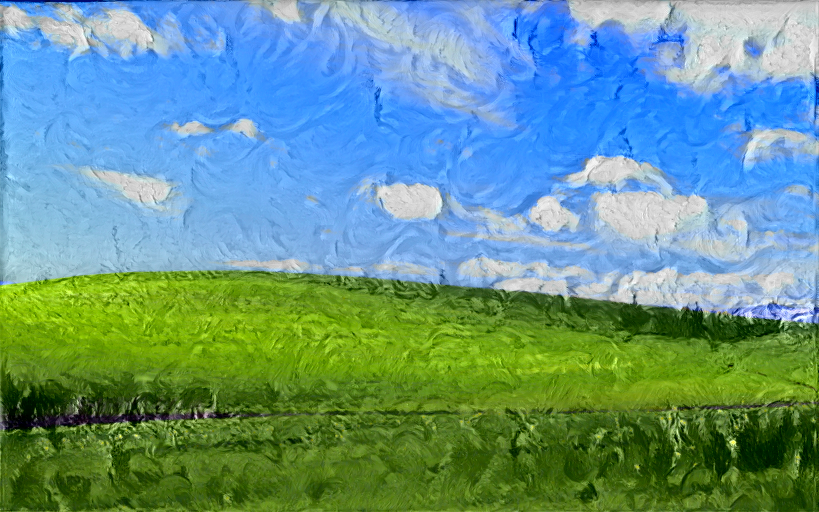

In [0]:
yuv_output_bands = list(output_transforms(output.clone().data[0].cpu().squeeze()).convert("YCbCr").split())
yuv_content_image_bands = list(output_transforms(content_image.clone().data[0].cpu().squeeze()).convert("YCbCr").split())

if normalize_band: # FIXME maybe do this normalization on the luminance channel of the style image, before style transfer (as it seems to be described in the article)
    output_stats = ImageStat.Stat(yuv_output_bands[0])
    content_image_stats = ImageStat.Stat(yuv_content_image_bands[0])
    
    sd_ratio = content_image_stats.stddev[0]/output_stats.stddev[0]
    output_mean = output_stats.mean[0]
    content_image_mean = content_image_stats.mean[0]
        
    yuv_output_bands[0] = yuv_output_bands[0].point(lambda p: sd_ratio * (p-output_mean) + content_image_mean)

lo_output = Image.merge("YCbCr", (yuv_output_bands[0], yuv_content_image_bands[1], yuv_content_image_bands[2])).convert("RGB")

lo_output.save(output_pattern.format("luminance_only"))
lo_output

### Color histogram matching

Modification of the style image so that the means+covariance matrix of the style image correspond to those of the content image.

**Disclaimer:** The following cells must be executed AFTER the initialization cells of the first section, and BEFORE the style transfer.

In [0]:
def covariance_matrix(input):
    batchsize, n_channels, height, width = input.shape
    
    input_reshaped = input.view(n_channels, -1)
    
    input_centered = input_reshaped - torch.mean(input_reshaped, 1, True)
    
    K = torch.mm(input_centered, input_centered.t())
    
    return K.div((height*width)-1) # divide by n-1 for an unbiased estimator

def tensor_pow(m, p):
    """
        Raises a 2 dimensional (matrix like) torch tensor to the power of p (m^p) and return the value. May not work if m isn't definite positive.
        
        :param m: PyTorch 2-Tensor
        :type m: torch.Tensor
        :param p: Power value
        :type p: float
        :return: Result
        :rtype: torch.Tensor
    """
    
    U, D, V = torch.svd(m)
    
    result = torch.mm(torch.mm(U, D.pow(p).diag()), V.t())
    
    return result

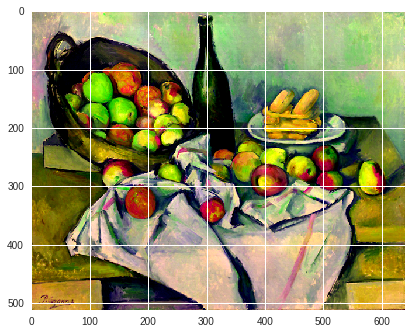

In [0]:
chm_style_image = style_image.clone()
chm_style_cov = covariance_matrix(chm_style_image)
chm_content_cov = covariance_matrix(content_image)
chm_style_means = torch.mean(chm_style_image.reshape(chm_style_image.shape[1], -1), 1, True)
chm_content_means = torch.mean(content_image.reshape(content_image.shape[1], -1), 1, True)

# For each pixel of the style image, we get the histogram matched version with p' = chm_A*p+chm_b
chm_A = torch.mm(tensor_pow(chm_content_cov, 0.5), tensor_pow(chm_style_cov, -0.5))
chm_b = chm_content_means - torch.mm(chm_A, chm_style_means)

# TODO find an quicker way to do this (maybe use Pillow?)
for i in range(chm_style_image.shape[2]):
    for j in range(chm_style_image.shape[3]):
        chm_style_image.squeeze()[:,i,j] = (torch.mm(chm_A, chm_style_image.squeeze()[:,i,j].unsqueeze(1)) + chm_b).squeeze()

imshow(output_transforms(chm_style_image.clone().data[0].cpu().squeeze()))  
show()

# Get the target features of the new style image
style_targets = [gram_matrix(f).detach() for f in model(chm_style_image)[1]]

## Scale control

By mixing different levels of layers of the neural network, we are able to get control over the scale of perceptual factors.

### Style mixing

A method to create a new style image by mixing 2 styles.

**TODO: Match color histogram of the new style with color histogram of the content image**

#### Creation of a new style

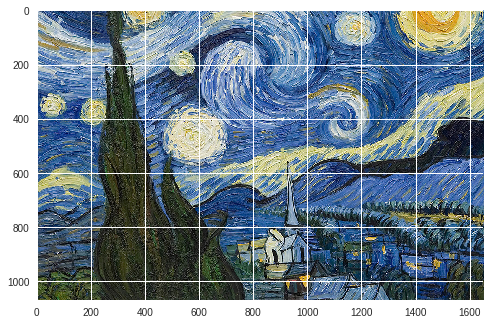

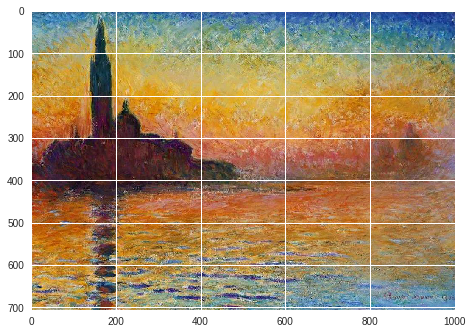

In [8]:
# Load and preprocess images
style_images = (Image.open(style_C_path), Image.open(style_F_path))
transformed_style_images = [input_transforms(i) for i in style_images]
if torch.cuda.is_available():
    transformed_style_images = (i.unsqueeze(0).cuda() for i in transformed_style_images)
else:
    transformed_style_images = (i.unsqueeze(0) for i in transformed_style_images)
style_C_image, style_F_image = transformed_style_images

for img in style_images:
    imshow(img)
    show()

In [0]:
# Create the style mixing model
mixture = StyleTransfer(content_layers=style_mixin_coarse_layers, style_layers=style_mixin_fine_layers)
for param in mixture.parameters():
    param.requires_grad_(False)
if torch.cuda.is_available():
    mixture.cuda()

# Initialize optimization process
if not as_texture:
    new_style = style_C_image.clone().requires_grad_(True)
else:
    new_style = torch.randn(style_C_image.size()).type_as(style_C_image.data).requires_grad_(True)

mixture_optimizer = optim.LBFGS([new_style])

# Get target features
coarse_targets = [f.detach() for f in mixture(style_C_image)[0]]
fine_targets = [gram_matrix(f).detach() for f in mixture(style_F_image)[1]]

In [11]:
!mkdir -p outputs
! rm -f outputs/*

generate(mixture, mixture_optimizer, epochs, 50, new_style, output_transforms, [1e0], [1./len(style_mixin_fine_layers)]*len(style_mixin_fine_layers), 0, coarse_targets, fine_targets)

#0: Content loss = 0.0, Style loss = 3054438912.0, Overall = 3054438912.0
#1
#2
#3
#4
#5
#6
#7
#8
#9
#10
#11
#12
#13
#14
#15
#16
#17
#18
#19
#20
#21
#22
#23
#24
#25
#26
#27
#28
#29
#30
#31
#32
#33
#34
#35
#36
#37
#38
#39
#40
#41
#42
#43
#44
#45
#46
#47
#48
#49
#50: Content loss = 172781.875, Style loss = 4040300.25, Overall = 4040300.25
#51
#52
#53
#54
#55
#56
#57
#58
#59
#60
#61
#62
#63
#64
#65
#66
#67
#68
#69
#70
#71
#72
#73
#74
#75
#76
#77
#78
#79
#80
#81
#82
#83
#84
#85
#86
#87
#88
#89
#90
#91
#92
#93
#94
#95
#96
#97
#98
#99
#100: Content loss = 185194.109375, Style loss = 653987.125, Overall = 653987.125
#101
#102
#103
#104
#105
#106
#107
#108
#109
#110
#111
#112
#113
#114
#115
#116
#117
#118
#119
#120
#121
#122
#123
#124
#125
#126
#127
#128
#129
#130
#131
#132
#133
#134
#135
#136
#137
#138
#139
#140
#141
#142
#143
#144
#145
#146
#147
#148
#149
#150: Content loss = 187070.40625, Style loss = 123564.5546875, Overall = 123564.5546875
#151
#152
#153
#154
#155
#156
#157
#158
#159
#160

#### Style transfer of the new style

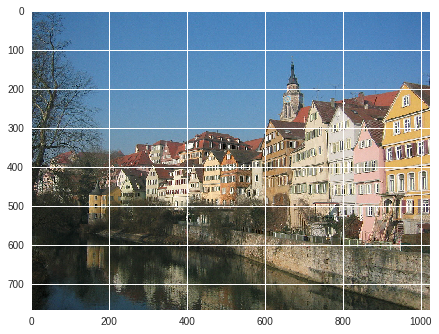

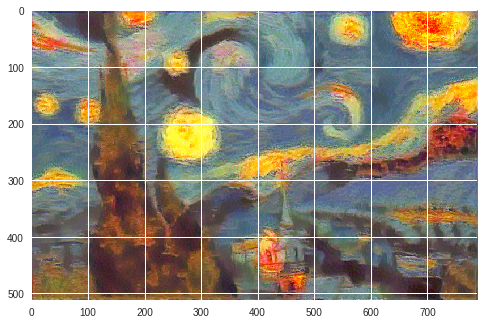

In [12]:
# Load and preprocess images
img = Image.open(mixed_content_path)
mixed_content_image = input_transforms(img)
if torch.cuda.is_available():
    mixed_content_image = mixed_content_image.unsqueeze(0).cuda()
else:
    mixed_content_image = mixed_content_image.unsqueeze(0)

imshow(img)
show()
imshow(output_transforms(new_style.clone().data[0].cpu().squeeze()))
show()

In [0]:
# Create the model
mixed_model = StyleTransfer(content_layers=content_layers, style_layers=style_layers)
for param in mixed_model.parameters():
    param.requires_grad_(False)
if torch.cuda.is_available():
    mixed_model.cuda()

# Initialize optimization process
if init_from_content:
    mixed_output = mixed_content_image.clone().requires_grad_(True)
else:
    mixed_output = torch.randn(mixed_content_image.size()).type_as(mixed_content_image.data).requires_grad_(True)

mixed_optimizer = optim.LBFGS([mixed_output])

# Get target features for both the content and style
mixed_content_targets = [f.detach() for f in mixed_model(mixed_content_image)[0]]
mixed_style_targets = [gram_matrix(f).detach() for f in mixed_model(new_style)[1]]

In [14]:
!mkdir -p outputs
! rm -f outputs/*

generate(mixed_model, mixed_optimizer, epochs, show_every, mixed_output, output_transforms, content_weights, style_weights, trade_off, mixed_content_targets, mixed_style_targets)

#0: Content loss = 0.0, Style loss = 482586496.0, Overall = 120646624.0
#1
#2
#3
#4
#5
#6
#7
#8
#9
#10
#11
#12
#13
#14
#15
#16
#17
#18
#19
#20: Content loss = 134538.28125, Style loss = 24066704.0, Overall = 6117579.5
#21
#22
#23
#24
#25
#26
#27
#28
#29
#30
#31
#32
#33
#34
#35
#36
#37
#38
#39
#40: Content loss = 143083.96875, Style loss = 11218287.0, Overall = 2911884.75
#41
#42
#43
#44
#45
#46
#47
#48
#49
#50
#51
#52
#53
#54
#55
#56
#57
#58
#59
#60: Content loss = 144863.75, Style loss = 5141714.5, Overall = 1394076.5
#61
#62
#63
#64
#65
#66
#67
#68
#69
#70
#71
#72
#73
#74
#75
#76
#77
#78
#79
#80: Content loss = 145516.65625, Style loss = 2602658.75, Overall = 759802.1875
#81
#82
#83
#84
#85
#86
#87
#88
#89
#90
#91
#92
#93
#94
#95
#96
#97
#98
#99
#100: Content loss = 144677.703125, Style loss = 1364474.25, Overall = 449626.84375
#101
#102
#103
#104
#105
#106
#107
#108
#109
#110
#111
#112
#113
#114
#115
#116
#117
#118
#119
#120: Content loss = 141154.421875, Style loss = 799850.6875, O

### Efficient high resolution

A way of quickly and efficiently generating high resolution outputs without losing large-scale style structures.

**FIXME: Upsample the original fullsize content and style image instead of the already downsampled tensors**

**Disclaimer:** The following cells will work if `output` stores the result of the cells of the first section.

#### Initialization 

In [0]:
# Upsample images for high resolution
hr_transformed_images = [hr_input_transforms(i) for i in images]
if torch.cuda.is_available():
    hr_transformed_images = (i.unsqueeze(0).cuda() for i in hr_transformed_images)
else:
    hr_transformed_images = (i.unsqueeze(0) for i in hr_transformed_images)
hr_content_image, hr_style_image = hr_transformed_images

hr_x_transforms = transforms.Compose([transforms.Resize(hr_content_image.shape[2:4])] + hr_input_transforms.transforms[1:]) # We need to force the resize of the output image to the same size as the hr_content_image (sometimes Resize seems to deduce a size varying of 1px for the largest side)
if torch.cuda.is_available():
    hr_output = hr_x_transforms(output_transforms(output.clone().data[0].cpu().squeeze())).unsqueeze(0).cuda()
else:
    hr_output = hr_x_transforms(output_transforms(output.clone().data[0].cpu().squeeze())).unsqueeze(0)

In [0]:
# Initialize optimization process
hr_output.requires_grad_(True)    
hr_optimizer = optim.LBFGS([hr_output])

# Get target features for both the content and style
hr_content_targets = [f.detach() for f in model(hr_content_image)[0]]
hr_style_targets = [gram_matrix(f).detach() for f in model(hr_style_image)[1]]

#### HR Style transfer (second step)

In [0]:
!mkdir -p outputs
!rm -f outputs/*

generate(model, hr_optimizer, hr_epochs, show_every, hr_output, output_transforms, content_weights, style_weights, trade_off, hr_content_targets, hr_style_targets)

#0: Content loss = 189496.8125, Style loss = 82522696.0, Overall = 20772796.0
#1
#2
#3
#4
#5
#6
#7
#8
#9
#10
#11
#12
#13
#14
#15
#16
#17
#18
#19
#20: Content loss = 183112.5625, Style loss = 547876.875, Overall = 274303.625
#21
#22
#23
#24
#25
#26
#27
#28
#29
#30
#31
#32
#33
#34
#35
#36
#37
#38
#39
#40: Content loss = 160672.125, Style loss = 154281.40625, Overall = 159074.4375
#41
#42
#43
#44
#45
#46
#47
#48
#49
#50
#51
#52
#53
#54
#55
#56
#57
#58
#59
#60: Content loss = 148632.84375, Style loss = 89449.0703125, Overall = 133836.90625
#61
#62
#63
#64
#65
#66
#67
#68
#69
#70
#71
#72
#73
#74
#75
#76
#77
#78
#79
#80: Content loss = 138592.078125, Style loss = 72799.203125, Overall = 122143.859375
#81
#82
#83
#84
#85
#86
#87
#88
#89
#90
#91
#92
#93
#94
#95
#96
#97
#98
#99
#100: Content loss = 131356.046875, Style loss = 65296.5546875, Overall = 114841.171875
#101
#102
#103
#104
#105
#106
#107
#108
#109
#110
#111
#112
#113
#114
#115
#116
#117
#118
#119
#120: Content loss = 126567.8828125, 